# importing

In [1]:
# Install TensorFlow (includes Keras)
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [3]:
%pip install opencv-python-headless


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [120]:
import os
import shutil
import random



source_dir = r"C:\Users\kaiva\Datasets\Osteoporosis_Knee_Dataset"
output_dir =r"C:\Users\kaiva\Datasets\osteoporosis_knee_split"


for split in ["train", "test"]:
    for label in ["osteoporosis", "normal"]:
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)


def get_images(class_name):
    folder = os.path.join(source_dir, class_name)
    return [os.path.join(folder, img) for img in os.listdir(folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]


for label in ["osteoporosis", "normal"]:
    images = get_images(label)
    random.shuffle(images)

    split_point = int(0.8 * len(images))
    train_imgs = images[:split_point]
    test_imgs = images[split_point:]

    for img_path in train_imgs:
        shutil.copy(img_path, os.path.join(output_dir, "train", label, os.path.basename(img_path)))

    for img_path in test_imgs:
        shutil.copy(img_path, os.path.join(output_dir, "test", label, os.path.basename(img_path)))

print(" Dataset split into 80% train and 20% test.")



 Dataset split into 80% train and 20% test.


# Set dataset paths

In [6]:

train_dir = r'C:\Users\kaiva\Datasets\osteoporosis_knee_split\train'
val_dir = r'C:\Users\kaiva\Datasets\osteoporosis_knee_split\test'

IMG_SIZE = 224

# Function to load data and extract features using MobileNetV2
def load_data_and_extract_features(base_dir):
    feature_list = []
    label_list = []
    labels_dict = {'Normal': 0, 'Osteoporosis': 1}
    mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')

    for label_name in ['Normal', 'Osteoporosis']:
        folder_path = os.path.join(base_dir, label_name)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            image = img_to_array(image)
            image = preprocess_input(image)
            image = np.expand_dims(image, axis=0)
            features = mobilenet_model.predict(image, verbose=0)
            feature_list.append(features.flatten())
            label_list.append(labels_dict[label_name])

    return np.array(feature_list), np.array(label_list)



# Disease Detection: Feature Extraction

In [7]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [8]:

start_time = time.time()
X_train, y_train = load_data_and_extract_features(train_dir)
X_val, y_val = load_data_and_extract_features(val_dir)
end_time = time.time()

print(f"Feature extraction time: {end_time - start_time:.2f} seconds") 



Feature extraction time: 78.74 seconds


# Train Logistic Regression

In [9]:
print(f"X_train shape: {np.shape(X_train)}")
print(f"y_train length: {len(y_train)}")


X_train shape: (372, 1280)
y_train length: 372


In [10]:
from tensorflow.keras.applications import MobileNetV2

mobilenet_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'  # This will give you a flat vector
)


In [11]:
import os
import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224

# Load MobileNetV2 model
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False,
                              input_shape=(IMG_SIZE, IMG_SIZE, 3),
                              pooling='avg')

def extract_features_from_directory(base_dir):
    feature_list = []
    label_list = []
    label_map = {'normal': 0, 'osteoporosis': 1}

    for label in ['normal', 'osteoporosis']:
        folder_path = os.path.join(base_dir, label)
        if not os.path.exists(folder_path):
            continue
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)

            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32')
            img = preprocess_input(img)
            img_array = np.expand_dims(img, axis=0)

            features = mobilenet_model.predict(img_array)
            feature_list.append(features.flatten())
            label_list.append(label_map[label])

    return np.array(feature_list), np.array(label_list)




In [12]:
train_dir = r'C:\Users\kaiva\Datasets\osteoporosis_knee_split\train'
val_dir = r'C:\Users\kaiva\Datasets\osteoporosis_knee_split\test'

X_train, y_train = extract_features_from_directory(train_dir)
X_val, y_val = extract_features_from_directory(val_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━

In [13]:
def extract_features_from_directory(base_dir):
    feature_list = []
    label_list = []
    label_map = {'normal': 0, 'osteoporosis': 1}

    for label in ['normal', 'osteoporosis']:
        folder_path = os.path.join(base_dir, label)
        print(f"Processing folder: {folder_path}")

        if not os.path.exists(folder_path):
            print(f"Folder does not exist: {folder_path}")
            continue

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not read image: {img_path}")
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = preprocess_input(img.astype('float32'))
            img_array = np.expand_dims(img, axis=0)

            features = mobilenet_model.predict(img_array)
            feature_list.append(features.flatten())
            label_list.append(label_map[label])

    print(f"Extracted {len(feature_list)} features.")
    return np.array(feature_list), np.array(label_list)


In [14]:
import os

normal_folder = r"C:\Users\kaiva\Datasets\osteoporosis_knee_split\train\normal"
print("Files in normal folder:", os.listdir(normal_folder)[:5])


Files in normal folder: ['10.png', '101.jpg', '104.jpg', '107.jpg', '11.jpg']


In [15]:
import os
import shutil
import random

source_dir = r"C:\Users\kaiva\Datasets\osteoporosis_knee_dataset"
dest_dir = r"C:\Users\kaiva\Datasets\osteoporosis_knee_split"
os.makedirs(dest_dir, exist_ok=True)

for split in ["train", "test"]:
    for label in ["normal", "osteoporosis"]:
        os.makedirs(os.path.join(dest_dir, split, label), exist_ok=True)

def collect_images(class_folder):
    # Correct: handle nested folder structure
    nested_folder = os.path.join(source_dir, class_folder, class_folder)
    return [os.path.join(nested_folder, f) for f in os.listdir(nested_folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Split the dataset
for label in ["normal", "osteoporosis"]:
    images = collect_images(label)
    random.shuffle(images)

    split_index = int(0.8 * len(images))
    train_images = images[:split_index]
    test_images = images[split_index:]

    for img_path in train_images:
        shutil.copy(img_path, os.path.join(dest_dir, "train", label))

    for img_path in test_images:
        shutil.copy(img_path, os.path.join(dest_dir, "test", label))

print("✅ Dataset split completed.")


✅ Dataset split completed.


In [16]:
print("Train normal:", os.listdir(r"C:\Users\kaiva\Datasets\osteoporosis_knee_split\train\normal")[:5])


Train normal: ['10.png', '101.jpg', '104.jpg', '107.jpg', '11.jpg']


In [17]:
X_train, y_train = extract_features_from_directory(train_dir)
X_val, y_val = extract_features_from_directory(val_dir)


Processing folder: C:\Users\kaiva\Datasets\osteoporosis_knee_split\train\normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━

In [18]:

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)  



LogisticRegression(max_iter=1000)

# Predict and Evaluate

In [19]:

y_pred = log_reg.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"\nDisease Detection Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=['Normal', 'Osteoporosis'])) 




Disease Detection Accuracy: 97.78%

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       137
Osteoporosis       0.97      0.98      0.98       133

    accuracy                           0.98       270
   macro avg       0.98      0.98      0.98       270
weighted avg       0.98      0.98      0.98       270



# Confusion Matrix

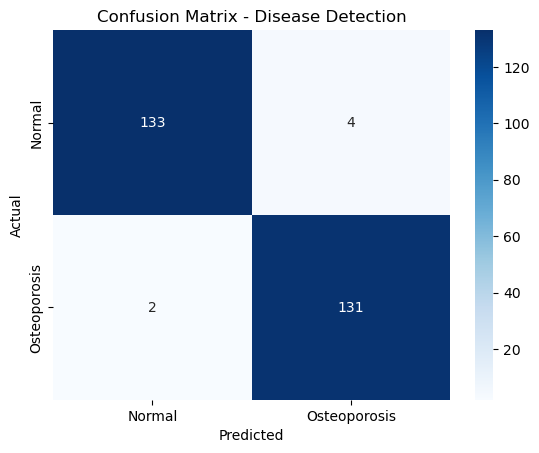

In [20]:

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Osteoporosis'], yticklabels=['Normal', 'Osteoporosis'])
plt.title('Confusion Matrix - Disease Detection')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show() 



# SEVERITY CLASSIFICATION

In [21]:
import os
import glob
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [22]:
# Step 1: Define a simple CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(name='flatten'),  # Name this layer to extract features
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\kaiva\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
import glob

image_dir = r'C:\Users\kaiva\Datasets\osteoporosis_knee_split\train'

# Collect images from all subfolders (e.g., train/normal/, train/osteoporosis/)
image_paths = glob.glob(os.path.join(image_dir, '**', '*.*'), recursive=True)

# Filter for image files only
image_paths = [p for p in image_paths if p.lower().endswith(('.jpg', '.jpeg', '.png'))]

print("Number of image paths found:", len(image_paths))
print("Sample paths:", image_paths[:5])


Number of image paths found: 372
Sample paths: ['C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\10.png', 'C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\101.jpg', 'C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\104.jpg', 'C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\107.jpg', 'C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\11.jpg']


In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
from tqdm import tqdm

# Assume `model` is your trained CNN model
# Replace 'flatten' with the actual layer name to extract features from


def extract_features(image_paths):
    features = []
    for path in tqdm(image_paths, desc="Extracting CNN features"):
        try:
            # Load and preprocess image
            img = image.load_img(path, target_size=(224, 224))
            img_array = image.img_to_array(img)

            # Convert grayscale to RGB if necessary
            if img_array.shape[-1] == 1:
                img_array = np.repeat(img_array, 3, axis=-1)

            img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize to [0, 1]

            # Extract features
            feature = feature_extractor.predict(img_array, verbose=0)
            features.append(feature.flatten())
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(features)



In [25]:
print("Number of image paths found:", len(image_paths))
print("Sample paths:", image_paths[:5])


Number of image paths found: 372
Sample paths: ['C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\10.png', 'C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\101.jpg', 'C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\104.jpg', 'C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\107.jpg', 'C:\\Users\\kaiva\\Datasets\\osteoporosis_knee_split\\train\\normal\\11.jpg']


In [42]:
features = extract_features(image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

In [43]:
print("Number of features extracted:", len(features))
if len(features) > 0:
    print("Feature shape for first image:", features[0].shape)
else:
    print("No features extracted.")


Number of features extracted: 372
Feature shape for first image: (1,)


In [44]:
def extract_features(image_paths):
    features = []
    for path in image_paths:
        try:
            img = cv2.imread(path)
            if img is None:
                print(f"Could not read: {path}")
                continue
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)

            feature = model.predict(img)
            features.append(feature.flatten())
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(features)


In [45]:
features = extract_features(image_paths)
print("Extracted features:", features.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [46]:
from sklearn.cluster import KMeans

features = extract_features(image_paths)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

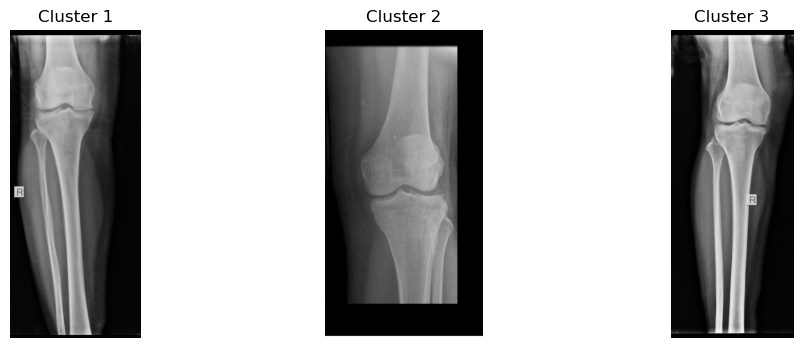

In [47]:

kmeans = KMeans(n_clusters=3, random_state=42)  # Here we assume 3 clusters (Low, Medium, High)
kmeans.fit(features)


labels = kmeans.labels_


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    cluster_images = [img_path for img_path, label in zip(image_paths, labels) if label == i]
    axes[i].imshow(cv2.imread(cluster_images[0]))  # Show first image in each cluster
    axes[i].set_title(f"Cluster {i + 1}")
    axes[i].axis('off')

plt.show()



In [48]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source and destination directories
source_dir = r'C:\Users\kaiva\Datasets\severity_data_unsupervised\train'
val_dir = r'C:\Users\kaiva\Datasets\severity_data_unsupervised\validation'

# Create the validation directory if it doesn't exist
os.makedirs(val_dir, exist_ok=True)

# Create subdirectories for 'Low', 'Medium', 'High' in the validation directory
for folder in ['Low', 'Medium', 'High']:
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)

# Step 1: Split the images for each cluster
for cluster_name in ['Low', 'Medium', 'High']:
    cluster_dir = os.path.join(source_dir, cluster_name)
    
    # Get a list of image files in the current cluster directory
    image_files = [f for f in os.listdir(cluster_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Step 2: Split the files into training and validation sets (80% training, 20% validation)
    train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)
    
    # Step 3: Move the files to their respective directories
    for file in val_files:
        src = os.path.join(cluster_dir, file)
        dst = os.path.join(val_dir, cluster_name, file)
        shutil.move(src, dst)

    print(f"Moved {len(val_files)} images to the validation set in {cluster_name} folder.")

print("Data has been split into training and validation sets.")


Moved 7 images to the validation set in Low folder.
Moved 9 images to the validation set in Medium folder.
Moved 4 images to the validation set in High folder.
Data has been split into training and validation sets.


In [49]:
# ---------------- SEVERITY CLASSIFICATION ----------------
# Assumption: images already separated by severity (Low, Medium, High)
# Create a folder: severity_data/train/[Low, Medium, High] and same for val

severity_train_dir = r'C:\Users\kaiva\Datasets\severity_data_unsupervised\train'
severity_val_dir = r'C:\Users\kaiva\Datasets\severity_data_unsupervised\validation'

# Load severity data
def load_severity_data(base_dir):
    data = []
    labels = []
    severity_map = {'Low': 0, 'Medium': 1, 'High': 2}
    for label in severity_map.keys():
        path = os.path.join(base_dir, label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (128, 128))
            data.append(image)
            labels.append(severity_map[label])
    return np.array(data)/255.0, to_categorical(labels, num_classes=3)

X_train_sev, y_train_sev = load_severity_data(severity_train_dir)
X_val_sev, y_val_sev = load_severity_data(severity_val_dir)   



 # Build CNN for Severity Classification

In [50]:

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_sev, y_train_sev, epochs=45, batch_size=32, validation_data=(X_val_sev, y_val_sev)) 



Epoch 1/45


C:\Users\kaiva\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.4388 - loss: 1.3605 - val_accuracy: 0.6182 - val_loss: 0.8605
Epoch 2/45
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.8250 - loss: 0.5631 - val_accuracy: 0.7864 - val_loss: 0.6009
Epoch 3/45
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8726 - loss: 0.4107 - val_accuracy: 0.8955 - val_loss: 0.3073
Epoch 4/45
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9475 - loss: 0.2166 - val_accuracy: 0.9273 - val_loss: 0.2125
Epoch 5/45
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.9480 - loss: 0.1648 - val_accuracy: 0.9227 - val_loss: 0.2023
Epoch 6/45
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.9746 - loss: 0.0827 - val_accuracy: 0.9136 - val_loss: 0.2191
Epoch 7/45
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.9732 - loss: 0.1161 - val_accuracy: 0.9273 - val_loss: 0.1690
Epoch 8/45
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.9703 - loss: 0.0738 - val_accuracy: 0.9318 - val_loss: 0.1737
Epo

 # Evaluate severity model

In [51]:

val_loss, val_acc = cnn_model.evaluate(X_val_sev, y_val_sev, verbose=0)
print(f"\nSeverity Classification Accuracy: {val_acc * 100:.2f}%")




Severity Classification Accuracy: 92.73%


In [52]:
y_pred_probs = cnn_model.predict(X_val_sev)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val_sev, axis=1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



Severity Classification Report:
               precision    recall  f1-score   support

         Low       0.95      0.91      0.93        81
      Medium       0.91      0.95      0.93       101
        High       0.94      0.89      0.92        38

    accuracy                           0.93       220
   macro avg       0.93      0.92      0.93       220
weighted avg       0.93      0.93      0.93       220



<Axes: >

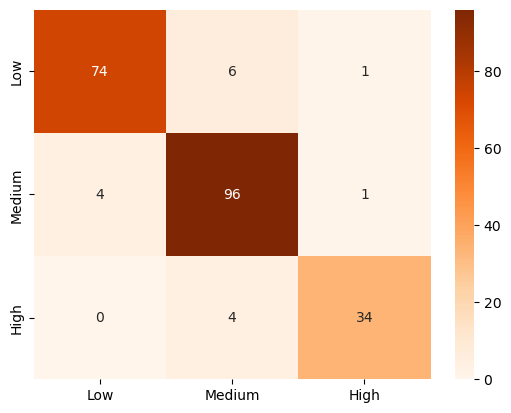

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

print("\nSeverity Classification Report:\n", 
      classification_report(
          y_true_classes, y_pred_classes, 
          labels=[0, 1, 2],
          target_names=['Low', 'Medium', 'High'],
          zero_division=0))

cm_sev = confusion_matrix(y_true_classes, y_pred_classes, labels=[0, 1, 2])
sns.heatmap(cm_sev, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Low', 'Medium', 'High'], 
            yticklabels=['Low', 'Medium', 'High'])


In [54]:
import os
import glob
import random
import numpy as np
from tensorflow.keras.preprocessing import image

# 1. Get all image paths
image_dir = r'C:\Users\kaiva\Datasets\osteoporosis_knee_split\train'
image_paths = glob.glob(os.path.join(image_dir, '**', '*.*'), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 2. Pick a random image
random_path = random.choice(image_paths)
print("Random image selected:", random_path)

# 3. Load and preprocess the image
img = image.load_img(random_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Convert grayscale to RGB if needed
if img_array.shape[-1] == 1:
    img_array = np.repeat(img_array, 3, axis=-1)

img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# 4. Predict using your trained model
disease_pred_prob = model.predict(img_array, verbose=0)
disease_pred = (disease_pred_prob > 0.5).astype(int)

# 5. Show result
class_labels = ['normal', 'osteoporosis']  # Adjust if reversed in training
predicted_label = class_labels[int(disease_pred)]

print("Prediction probability:", disease_pred_prob[0][0])
print("Predicted class:", predicted_label)



Random image selected: C:\Users\kaiva\Datasets\osteoporosis_knee_split\train\osteoporosis\54.png
Prediction probability: 0.5036433
Predicted class: osteoporosis


C:\Users\kaiva\AppData\Local\Temp\ipykernel_28960\2659417540.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_labels[int(disease_pred)]


In [55]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


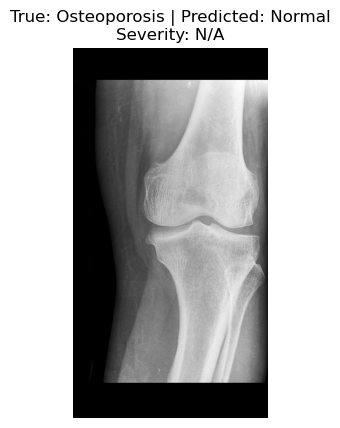

Image path: C:\Users\kaiva\Datasets\osteoporosis_knee_split\test\osteoporosis\105.png
True Disease Label: Osteoporosis
Predicted Disease Label: Normal
No severity prediction (Normal case).


In [119]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Load class names
disease_class_names = ['Normal', 'Osteoporosis']
severity_class_names = ['Low', 'Medium', 'High']

# Path to test image directory (manually put some labeled test images here)
test_dir = r'C:\Users\kaiva\Datasets\osteoporosis_knee_split\test'
all_test_images = []

# Collect all test image paths
for label in ['normal', 'osteoporosis']:
    label_path = os.path.join(test_dir, label)
    for img_file in os.listdir(label_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_test_images.append((os.path.join(label_path, img_file), label))

# Pick a random image
image_path, true_disease_label = random.choice(all_test_images)
image = cv2.imread(image_path)
image_resized = cv2.resize(image, (128, 128)) / 255.0
image_input = np.expand_dims(image_resized, axis=0)

# Predict disease (Normal / Osteoporosis)
disease_pred_prob = mobilenet_model.predict(image_input)
disease_pred = np.argmax(disease_pred_prob)
predicted_disease_label = disease_class_names[disease_pred]

# Predict severity only if predicted as Osteoporosis
predicted_severity_label = 'N/A'
if predicted_disease_label == 'Osteoporosis':
    severity_pred_prob = cnn_model.predict(image_input)
    severity_pred = np.argmax(severity_pred_prob)
    predicted_severity_label = severity_class_names[severity_pred]

# Display results
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"True: {true_disease_label.title()} | Predicted: {predicted_disease_label}\nSeverity: {predicted_severity_label}")
plt.show()

# Print detailed output
print(f"Image path: {image_path}")
print(f"True Disease Label: {true_disease_label.title()}")
print(f"Predicted Disease Label: {predicted_disease_label}")
if predicted_disease_label == 'Osteoporosis':
    print(f"Predicted Severity Level: {predicted_severity_label}")
else:
    print("No severity prediction (Normal case).")


In [41]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image (example)
img_path = r"C:\Users\kaiva\Datasets\Osteoporosis_Knee_Dataset\osteoporosis\osteoporosis\1.JPEG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

# Convert grayscale to RGB if necessary
if img_array.shape[-1] == 1:
    img_array = np.repeat(img_array, 3, axis=-1)

img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Get prediction probabilities
disease_pred_prob = mobilenet_model.predict(img_array, verbose=0)

# For binary classification, threshold at 0.5
disease_pred = (disease_pred_prob > 0.5).astype(int)

print("Disease prediction probabilities:", disease_pred_prob)
print("Predicted class index:", disease_pred)


Disease prediction probabilities: [[0.1369423  0.86305773]]
Predicted class index: [[0 1]]
